# RL Testing Notebook

Here I plan on testing different aspects of the RL algorithm

In [1]:
%pylab inline
import seaborn as sns
from dphutils import fft_pad
from scipy.signal import fftconvolve
from scipy.ndimage.interpolation import shift
from itertools import product, combinations
from dphplotting import slice_plot, display_grid

Populating the interactive namespace from numpy and matplotlib


## Roll functions

It seems pretty obvious that in certain situations we'll need to roll axes, the question is how much of a speed hit is it

In [2]:
a = ones(2**16)
%timeit roll(a, -1)

29.8 µs ± 422 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [3]:
%timeit a[::-1]

210 ns ± 2.62 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [4]:
%timeit rfft(a)

809 µs ± 79.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
a = arange(2**16).reshape(2**8,2**8)

In [6]:
%timeit roll(roll(a, 1, axis=1), 1, axis=0)

63.9 µs ± 4.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
def rollmulti(a, shift):
    """"""
    for i in range(a.ndim):
        a = roll(a, shift, i)
    return a

In [8]:
%timeit rollmulti(a, 1)

69 µs ± 5.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## RL Stuff

In [9]:
def rl_core_matlab(image, psf, y_t):
    """The core update step of the RL algorithm"""    
    otf = rfftn(ifftshift(fft_pad(psf, image.shape, mode="constant")))
    reblur = irfftn(otf * rfftn(y_t), y_t.shape)
    reblur = ensure_positive(reblur)
    im_ratio = image / reblur
    estimate = irfftn(np.conj(otf) * rfftn(im_ratio), im_ratio.shape)
    return y_t * estimate

def rl_core_accurate(image, psf, y_t):
    """The core update step of the RL algorithm
    
    An accurate version"""
    reblur = fftconvolve(y_t, psf, "same")
    reblur = ensure_positive(reblur)
    im_ratio = image / reblur
    # reverse slicing
    s = slice(None, None, -1)
    estimate = fftconvolve(im_ratio, psf[(s, ) * psf.ndim], "same")
    return y_t * estimate

def rl_core_fast(image, psf, y_t):
    """The core update step of the RL algorithm
    
    Fast version"""
    pad_psf = fft_pad(psf, image.shape, mode="constant")
    otf = rfftn(ifftshift(pad_psf))
    reblur = irfftn(otf * rfftn(y_t), y_t.shape)
    reblur = ensure_positive(reblur)
    im_ratio = image / reblur
    estimate = irfftn(np.conj(otf) * rfftn(im_ratio), im_ratio.shape)
    for i, (s, p) in enumerate(zip(image.shape, psf.shape)):
        if s % 2 and not p % 2:
            estimate = roll(estimate, 1, i)
    return y_t * estimate

In [10]:
def richardson_lucy(image, psf, iterations=10, core=rl_core_accurate, guess=False):
    """Richardson-Lucy deconvolution."""
    # initialize variable for iterations
    # previous estimate
    u_tm1 = None
    # current estimate
    if guess:
        u_t = image
    else:
        u_t = ones_like(image) * image.mean()
    # previous difference
    g_tm1 = None
    for i in range(iterations):
        # call the update function
        u_tp1 = core(image, psf, u_t)
        # enure positivity
        u_t = ensure_positive(u_tp1)
    # return final estimate
    return u_tp1

def ensure_positive(data):
    """Make sure data is positive and has no zeros

    For numerical stability

    If we realize that mutating data is not a problem
    and that changing in place could lead to signifcant
    speed ups we can lose the data.copy() line"""
    # make a copy of the data
    data = data.copy()
    data[data <= 0] = np.finfo(data.dtype).resolution
    return data

### 1D Examples

Check the algorithm with 1 dimensional examples first.

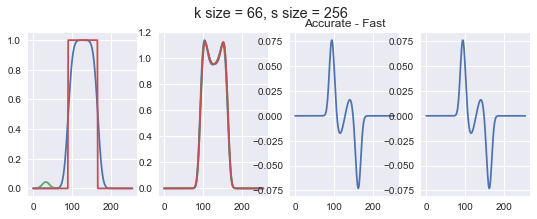

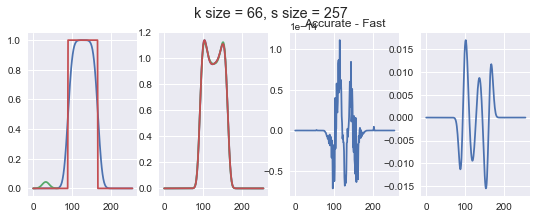

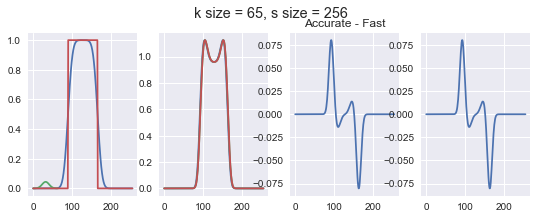

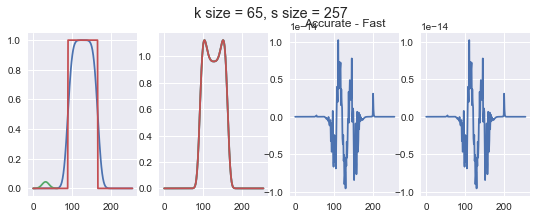

In [11]:
for k_size, s_size in product((66, 65), (256, 257)):
    # make kernel
    x = linspace(-2.5, 2.5, k_size, True)
    k = exp(-x**2)
    # normalize kernel
    k /= k.sum()
    # make signal
    x = linspace(-10, 10, s_size)
    f = logical_and(x < 3, x > -3)
    
    y = fftconvolve(f, k, "same")
    y = ensure_positive(y)
    k = ensure_positive(k)
    decon_a = richardson_lucy(y, k)
    decon_m = richardson_lucy(y, k, core=rl_core_matlab)
    decon_f = richardson_lucy(y, k, core=rl_core_fast)
    
    fig, (ax0, ax1, ax2, ax3) = subplots(1, 4, figsize=(9,3))
    
    ax0.plot(y)
    ax0.plot(k)
    ax0.plot(f)
    
    ax1.plot(decon_a)
    ax1.plot(decon_m)
    ax1.plot(decon_f)
    
    # plot differences
    ax2.plot(decon_a - decon_f)
    ax2.set_title("Accurate - Fast")
    ax3.plot(decon_a - decon_m, label="Accurate - matlab")
    # ax2.plot(decon_m - decon_f, label="matlab - Fast")
    fig.suptitle("k size = {}, s size = {}".format(k_size, s_size), y=1)

### 2D Examples

Move on to two dimensions to see if there's any difference

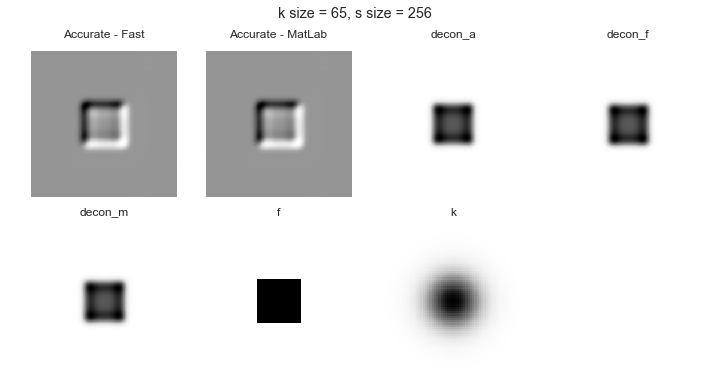

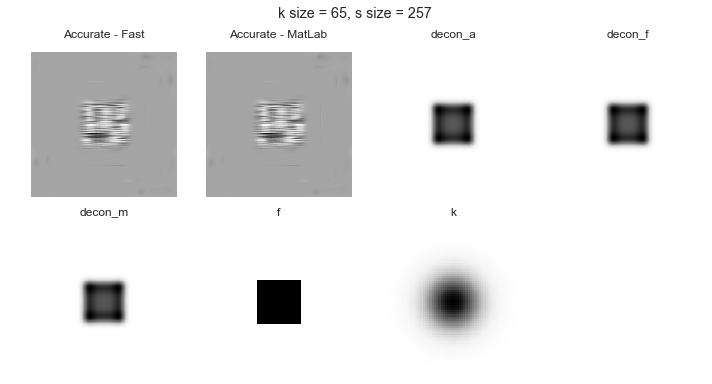

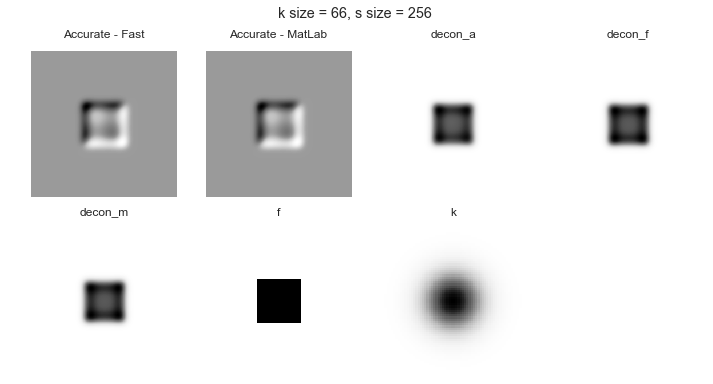

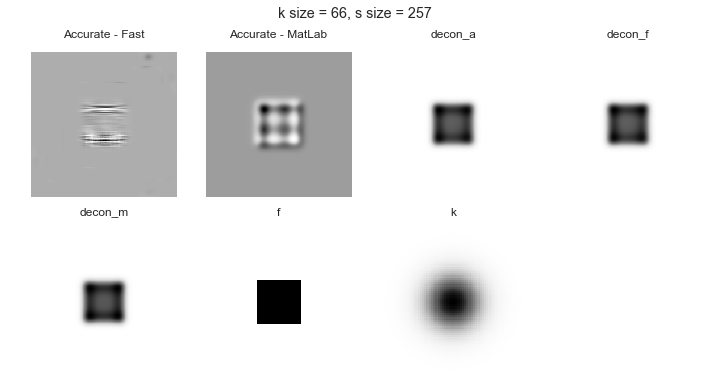

In [12]:
for k_size, s_size in product((65, 66), (256, 257)):
    # make kernel
    x = linspace(-2.5, 2.5, k_size, True)
    k = exp(-x**2)
    k = k[newaxis] * k[:, newaxis]
    # normalize kernel
    k /= k.sum()
    # make signal
    x = linspace(-10, 10, s_size)
    f = logical_and(x < 3, x > -3)
    f = f[newaxis] * f[:, newaxis]
    
    y = fftconvolve(f, k, "same")
    y = ensure_positive(y)
    k = ensure_positive(k)
    
    d = dict(
        f=f,
        k=k,
        decon_a= richardson_lucy(y, k),
        decon_m= richardson_lucy(y, k, core=rl_core_matlab),
        decon_f= richardson_lucy(y, k, core=rl_core_fast)
    )
    d["Accurate - Fast"] = (d["decon_a"] - d["decon_f"])
    d["Accurate - MatLab"] = d["decon_a"] - d["decon_m"]
    
    fig, axs = display_grid(d)
    
    fig.suptitle("k size = {}, s size = {}".format(k_size, s_size))

### Check the effects of noise

In [13]:
x = linspace(-2.5, 2.5, 66, True)
k = exp(-x**2)
k = k[newaxis] * k[:, newaxis]
# normalize kernel
k /= k.sum()
k = pad(k, ((1, 1), (10, 3)), "constant")
# make signal
x = linspace(-10, 10, 257)
f = logical_and(x < 3, x > -3)
f = f[newaxis] * f[:, newaxis]

y = fftconvolve(f, k, "same")
y = pad(y, ((20,20), (3,2)), "constant")
y = ensure_positive(y)
k = ensure_positive(k)

y[y < 0] = 0
yy = poisson(y * 100) + randn(*y.shape) ** 2
k[k < 0] = 0
kk = poisson(k * 1e6) + randn(*k.shape) ** 2
kk /= kk.sum()

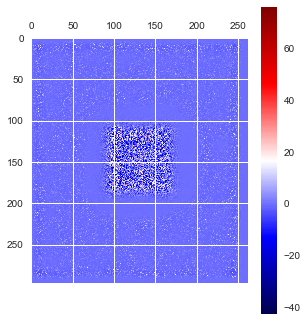

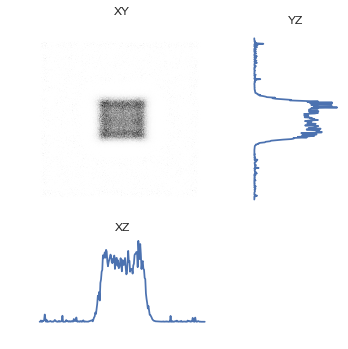

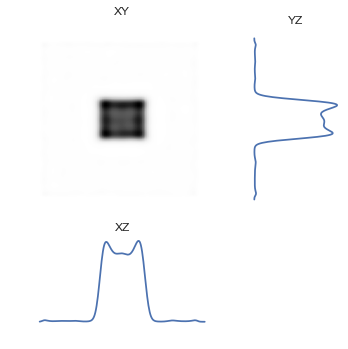

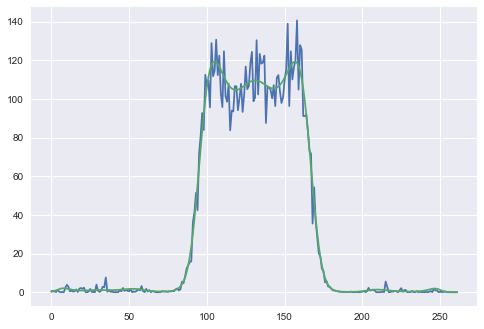

In [17]:
# also see the difference between using the image data as the first "guess" or using the mean value
with_guess = richardson_lucy(yy, k, 20, core=rl_core_accurate, guess=True)
without_guess = richardson_lucy(yy, k, 20, core=rl_core_accurate, guess=False)
matshow(with_guess - without_guess, cmap="seismic")
colorbar()
slice_plot(with_guess)
slice_plot(without_guess)
plt.figure()
plot(with_guess[128])
plot(without_guess[128])

In [15]:
y.shape

(297, 262)

The mean value is ___clearly___ superior. The result is nearly noiseless. This makes sense as any noise present at the beginning guess will be amplified throughout the algorithm.

In [16]:
from dphutils import richardson_lucy as old_rl

In [17]:
from scipy.signal import signaltools as sig

In [18]:
def get_fshapeslice(in1, in2):
    in1 = np.asarray(in1)
    in2 = np.asarray(in2)

    s1 = np.array(in1.shape)
    s2 = np.array(in2.shape)
    assert (s1 >= s2).all()
    shape = s1 + s2 - 1
    # Speed up FFT by padding to optimal size for FFTPACK
    fshape = [sig.fftpack.helper.next_fast_len(int(d)) for d in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    return fshape, fslice
# Pre-1.9 NumPy FFT routines are not threadsafe.  For older NumPys, make
# sure we only call rfftn/irfftn from one thread at a time.
# sp1 = rfftn(in1, fshape, threads=threads)
# sp2 = rfftn(in2, fshape, threads=threads)
# ret = (irfftn(sp1 * sp2, fshape, threads=threads)[fslice].copy())

In [19]:
def rl_core2(image, otf, iotf, y_t, fshape, fslice):
    """The core update step of the RL algorithm
    
    Fast version"""
    reblur = irfftn(rfftn(y_t, fshape) * otf, fshape)[fslice]
    reblur = sig._centered(reblur, image.shape)
    reblur = ensure_positive(reblur)
    im_ratio = image / reblur
    estimate = irfftn(rfftn(im_ratio, fshape) * iotf, fshape)[fslice]
    estimate = sig._centered(estimate, image.shape)
    return y_t * estimate

def richardson_lucy2(image, psf, iterations=10):
    """Richardson-Lucy deconvolution."""
    # initialize variable for iterations
    fshape, fslice = get_fshapeslice(image, psf)
    otf = rfftn(psf, fshape)
    iotf = rfftn(psf[::-1, ::-1], fshape)
    u_tm1 = None
    # current estimate
    u_t = ones_like(image) * image.mean()
    # previous difference
    g_tm1 = None
    for i in range(iterations):
        # call the update function
        u_tp1 = rl_core2(image, otf, iotf, u_t, fshape, fslice)
        # enure positivity
        u_t = ensure_positive(u_tp1)
    # return final estimate
    return u_tp1

(<matplotlib.figure.Figure at 0x1dec17a0b70>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DEC21A1940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001DEC16F15C0>], dtype=object))

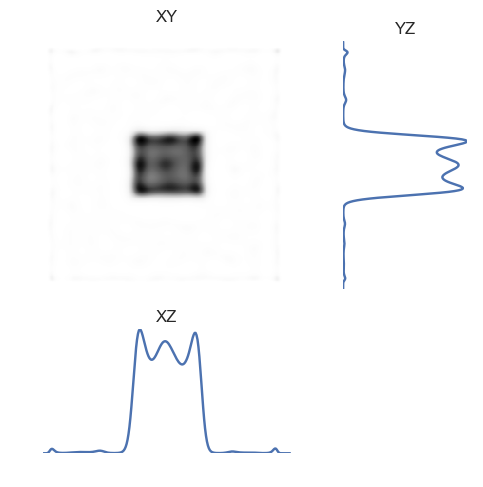

In [20]:
slice_plot(richardson_lucy2(yy, k, 100))

In [21]:
allclose(richardson_lucy2(yy, k, 20), richardson_lucy(yy, k, 20, core=rl_core_accurate, guess=False))

True

In [22]:
%timeit richardson_lucy2(yy, k, 20)
%timeit richardson_lucy(yy, k, 20, core=rl_core_accurate, guess=False)

1 loop, best of 3: 385 ms per loop
1 loop, best of 3: 463 ms per loop


In [23]:
%timeit richardson_lucy(yy, k, 20, core=rl_core_accurate, guess=False)
%timeit richardson_lucy(yy, k, 20, core=rl_core_fast, guess=False)
%timeit richardson_lucy2(yy, k, 20)

1 loop, best of 3: 464 ms per loop
1 loop, best of 3: 769 ms per loop
1 loop, best of 3: 383 ms per loop


In [24]:
d = dict(
    decon_a = richardson_lucy(yy, k, 20, core=rl_core_accurate, guess=False),
    decon_f = richardson_lucy(yy, k, 20, core=rl_core_fast, guess=False),
    decon_m = richardson_lucy(yy, k, 20, core=rl_core_matlab, guess=False),
    decon_fa = richardson_lucy2(yy, k, 20),
)

(<matplotlib.figure.Figure at 0x1dec1c69cf8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DEC1A65CF8>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x000001DEC47DD518>]], dtype=object))

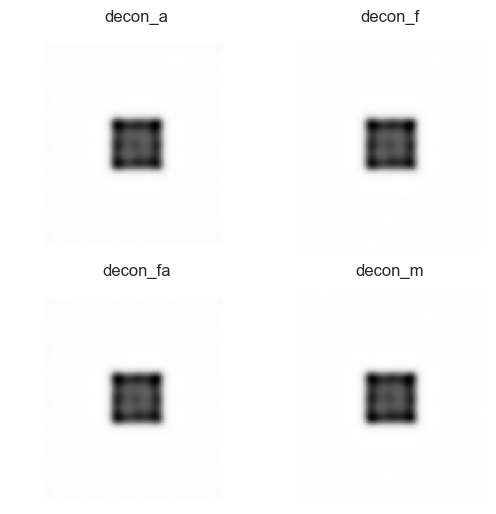

In [25]:
display_grid(d)

(<matplotlib.figure.Figure at 0x1dec347e588>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DEC3470BA8>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x000001DEC4483FD0>]], dtype=object))

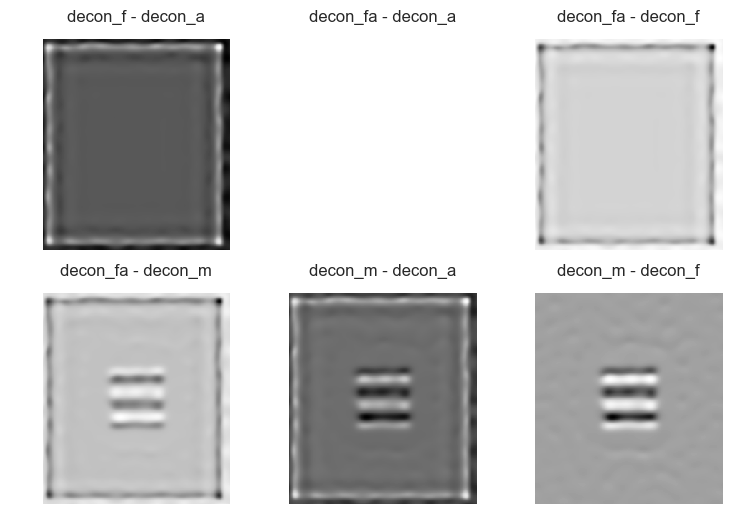

In [26]:
display_grid({k1 + " - " + k2:v1-v2 for (k1, v1), (k2, v2) in combinations(d.items(), 2)})

In [27]:
%load_ext autoreload
%autoreload 2
from pyDecon.decon import richardson_lucy as new_rl

In [33]:
allclose(new_rl(yy, k, 20, prediction_order=0), richardson_lucy(yy, k, 20, core=rl_core_accurate, guess=False))

True

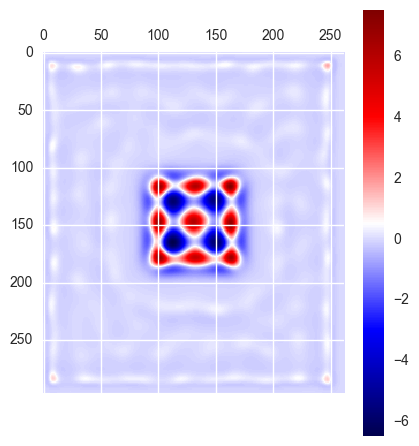

In [36]:
matshow(new_rl(yy, k, 20, prediction_order=2) - new_rl(yy, k, 20, prediction_order=0), cmap="seismic")
colorbar()

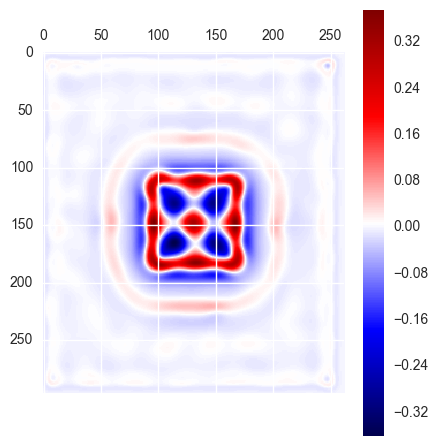

In [48]:
matshow(new_rl(yy, k, 13, prediction_order=1) - new_rl(yy, k, 20, prediction_order=0), cmap="seismic")
colorbar()

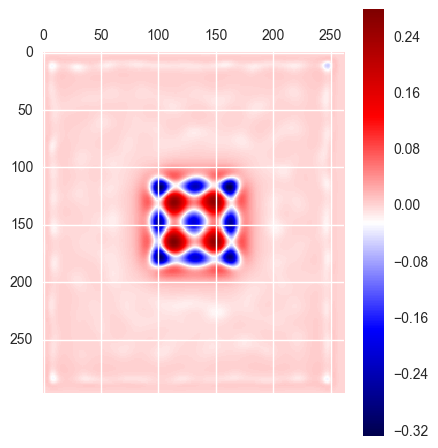

In [43]:
matshow(new_rl(yy, k, 14, prediction_order=2) - new_rl(yy, k, 20, prediction_order=0), cmap="seismic")
colorbar()

In [49]:
%timeit richardson_lucy(yy, k, 20, core=rl_core_accurate, guess=False)
%timeit richardson_lucy(yy, k, 20, core=rl_core_fast, guess=False)
%timeit new_rl(yy, k, 20, 0)
%timeit new_rl(yy, k, 20, 1)
%timeit new_rl(yy, k, 13, 1)

1 loop, best of 3: 468 ms per loop
1 loop, best of 3: 762 ms per loop
10 loops, best of 3: 164 ms per loop
10 loops, best of 3: 174 ms per loop
10 loops, best of 3: 114 ms per loop


In [53]:
%timeit new_rl(yy, k, 13, 1, threads=1)
%timeit new_rl(yy, k, 13, 1, threads=2)
%timeit new_rl(yy, k, 13, 1, threads=4)
%timeit new_rl(yy, k, 13, 1, threads=8)
%timeit new_rl(yy, k, 13, 1, threads=16)

10 loops, best of 3: 113 ms per loop
10 loops, best of 3: 110 ms per loop
10 loops, best of 3: 93.1 ms per loop
10 loops, best of 3: 90.1 ms per loop
10 loops, best of 3: 93.7 ms per loop


In [58]:
import pyfftw

In [65]:
x = linspace(-2.5, 2.5, 64, True)
k = exp(-x**2)
k = k[newaxis] * k[:, newaxis]
# normalize kernel
k /= k.sum()
# make signal
x = linspace(-10, 10, 512)
f = logical_and(x < 3, x > -3)
f = f[newaxis] * f[:, newaxis]

y = fftconvolve(f, k, "same")
y = ensure_positive(y)
k = ensure_positive(k)

y[y < 0] = 0
yy = poisson(y * 100) + randn(*y.shape) ** 2
k[k < 0] = 0
kk = poisson(k * 1e6) + randn(*k.shape) ** 2
kk /= kk.sum()
pyfftw.forget_wisdom()
start = time.time()
%time new_rl(yy, k, 13, 1, threads=1)
end = "g"

Wall time: 1.46 s


In [60]:
import time

In [63]:
time.time()

1477619357.038164

### Let's try a bigger problem to see if more threads is better

In [54]:
x = linspace(-2.5, 2.5, 65, True)
k = exp(-x**2)
k = k[newaxis] * k[:, newaxis]
# normalize kernel
k /= k.sum()
k = pad(k, ((1, 1), (10, 3)), "constant")
# make signal
x = linspace(-10, 10, 2048)
f = logical_and(x < 3, x > -3)
f = f[newaxis] * f[:, newaxis]

y = fftconvolve(f, k, "same")
y = pad(y, ((20,20), (3,2)), "constant")
y = ensure_positive(y)
k = ensure_positive(k)

y[y < 0] = 0
yy = poisson(y * 100) + randn(*y.shape) ** 2
k[k < 0] = 0
kk = poisson(k * 1e6) + randn(*k.shape) ** 2
kk /= kk.sum()

%timeit new_rl(yy, k, 13, 1, threads=1)
%timeit new_rl(yy, k, 13, 1, threads=2)
%timeit new_rl(yy, k, 13, 1, threads=4)
%timeit new_rl(yy, k, 13, 1, threads=8)
%timeit new_rl(yy, k, 13, 1, threads=16)

1 loop, best of 3: 10.9 s per loop
1 loop, best of 3: 9.18 s per loop
1 loop, best of 3: 8.59 s per loop
1 loop, best of 3: 8.42 s per loop
1 loop, best of 3: 8.38 s per loop


In [55]:
%timeit new_rl(yy, k, 13, 1, planner_effort="FFTW_PATIENT")
%timeit new_rl(yy, k, 13, 1, planner_effort="FFTW_EXHAUSTIVE")

The slowest run took 91.16 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 10.1 s per loop
The slowest run took 268.40 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 10.9 s per loop
